# Stitch
---

#### Overview
Interactive stitching of one or several sections.

In [1]:
# indirectly enable autocomplete
%config Completer.use_jedi = False

# autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import requests

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import renderapi

from scripted_render_pipeline import basic_auth

#### `render-ws` environment variables

In [3]:
# # render-ws environment variables
# params_render = {
#     "host": "https://sonic.tnw.tudelft.nl",
#     "owner": "fastem",
#     "project": "20230712_RF_zstack",
#     "auth": basic_auth.load_auth()
# }

# create an authorized session
auth = basic_auth.load_auth()
sesh = requests.Session()
sesh.auth = auth

# render-ws environment variables
params_render = {
    "host": "http://localhost",
    "port": 8081,
    "client_scripts": "/home/catmaid/render/render-ws-java-client/src/main/scripts",
    "client_script": "/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh",
    "owner": "fastem",
    "project": "20230712_RF_zstack",
    "session": sesh
}

# set project directory
dir_project = pathlib.Path("/long_term_storage/asm_storage/asm_service/2023-07-12/20230712_RF_zstack/")

## Stitching (part I)
---
Get tile pairs. Get point matches.

### Get tile pairs

Use render-ws `tilePairClient` to get the set of tile pairs.

In [4]:
# choose stack from which to get tile pairs
stack = "corrected"
z_values = [int(z) for z in renderapi.stack.get_z_values_for_stack(
    stack,
    **params_render
)]

# Get tile pairs from the rough aligned stack
tilepairs = renderapi.client.tilePairClient(
    stack=stack,
    minz=min(z_values),
    maxz=max(z_values),
    zNeighborDistance=0,  # half-height of search cylinder
    excludeSameLayerNeighbors=False,
    subprocess_mode="check_output",  # suppresses output
    **params_render
)["neighborPairs"]

# Show tile pairs
out = f"Number of tile pairs... {len(tilepairs)}"
print(out, "\n" + "-"*len(out))
tilepairs[:5]

Number of tile pairs... 204 
---------------------------


[{'p': {'groupId': 'RF_brain_section_10_10us',
   'id': 't0_z8_y2_x2',
   'relativePosition': 'BOTTOM'},
  'q': {'groupId': 'RF_brain_section_10_10us',
   'id': 't3_z8_y1_x2',
   'relativePosition': 'TOP'}},
 {'p': {'groupId': 'RF_brain_section_10_10us',
   'id': 't0_z8_y2_x2',
   'relativePosition': 'RIGHT'},
  'q': {'groupId': 'RF_brain_section_10_10us',
   'id': 't1_z8_y2_x1',
   'relativePosition': 'LEFT'}},
 {'p': {'groupId': 'RF_brain_section_10_10us',
   'id': 't1_z8_y2_x1',
   'relativePosition': 'BOTTOM'},
  'q': {'groupId': 'RF_brain_section_10_10us',
   'id': 't4_z8_y1_x1',
   'relativePosition': 'TOP'}},
 {'p': {'groupId': 'RF_brain_section_10_10us',
   'id': 't1_z8_y2_x1',
   'relativePosition': 'RIGHT'},
  'q': {'groupId': 'RF_brain_section_10_10us',
   'id': 't2_z8_y2_x0',
   'relativePosition': 'LEFT'}},
 {'p': {'groupId': 'RF_brain_section_10_10us',
   'id': 't2_z8_y2_x0',
   'relativePosition': 'BOTTOM'},
  'q': {'groupId': 'RF_brain_section_10_10us',
   'id': 't5_z8_

### Get point matches

Use `render-ws` `PointMatchClient` script to find matching features between the neighboring megafields.

In [5]:
from renderapi.client import (
    SiftPointMatchOptions,
    MatchDerivationParameters,
    FeatureExtractionParameters
)

In [7]:
# Name for pointmatch collection
match_collection = f"{params_render['project']}_{stack}_matches"
match_collection

'20230712_RF_zstack_corrected_matches'

#### Set SIFT + RANSAC parameters

In [6]:
# `RANSAC` parameters
params_RANSAC = MatchDerivationParameters(
    matchIterations=None,
    matchMaxEpsilon=25,        # maximal alignment error
    matchMaxNumInliers=None,
    matchMaxTrust=None,
    matchMinInlierRatio=0.05,  # minimal inlier ratio
    matchMinNumInliers=7,      # minimal number of inliers
    matchModelType='AFFINE',   # expected transformation
    matchRod=0.92              # closest/next closest ratio
)

# `SIFT` parameters
params_SIFT = FeatureExtractionParameters(
    SIFTfdSize=8,              # feature descriptor size
    SIFTmaxScale=0.30,         # (width/height *) maximum image size
    SIFTminScale=0.20,         # (width/height *) minimum image size
    SIFTsteps=5                # steps per scale octave
)

# Combined `SIFT` & `RANSAC` parameters
params_SIFT = SiftPointMatchOptions(
    fillWithNoise=True,
    **{**params_RANSAC.__dict__,
       **params_SIFT.__dict__}
)

# Extra parameters
params_SIFT.numberOfThreads = 1  # multithreading
params_SIFT.clipWidth = 640      # N pixels included in rendered clips of LEFT/RIGHT oriented montage tiles
params_SIFT.clipHeight = 640     # N pixels included in rendered clips of TOP/BOTTOM oriented montage tiles
params_SIFT.__dict__

{'SIFTfdSize': 8,
 'SIFTmaxScale': 0.3,
 'SIFTminScale': 0.2,
 'SIFTsteps': 5,
 'matchIterations': None,
 'matchMaxEpsilon': 25,
 'matchMaxNumInliers': None,
 'matchMaxTrust': None,
 'matchMinInlierRatio': 0.05,
 'matchMinNumInliers': 7,
 'matchModelType': 'AFFINE',
 'matchRod': 0.92,
 'renderScale': None,
 'fillWithNoise': True,
 'numberOfThreads': 1,
 'clipWidth': 640,
 'clipHeight': 640}

#### Execute SIFT + RANSAC

In [8]:
# Loop through tile pairs
for tp in tqdm(tilepairs):

    # Format tile pair
    tp_ids = (tp["p"]["id"], tp["q"]["id"])

    # Provide relative position of first tile so that the
    # client script knows how to clip the images properly
    params_SIFT.firstCanvasPosition = tp["p"]["relativePosition"]

    # Run SIFT + RANSAC via render-ws PointMatchClient
    renderapi.client.pointMatchClient(
        stack=stack,
        collection=match_collection,
        tile_pairs=[tp_ids],
        sift_options=params_SIFT,
        excludeAllTransforms=True,
        subprocess_mode='check_output',  # suppresses output
        **params_render
    )

  0%|          | 0/204 [00:00<?, ?it/s]

### Collect point matches

In [9]:
# Collection
d_matches = {}

# Loop through each section
for z in tqdm(z_values):

    # Get sectionId from z value
    sectionId = renderapi.stack.get_sectionId_for_z(
        stack=stack,
        z=z,
        **params_render
    )

    # Get all the point matches within each section
    matches = renderapi.pointmatch.get_matches_with_group(
        pgroup=sectionId,
        matchCollection=match_collection,
        **params_render
    )

    # Add to collection
    d_matches[z] = matches

  0%|          | 0/17 [00:00<?, ?it/s]

### Inspect

In [10]:
from interactive_render import plotting

  0%|          | 0/17 [00:00<?, ?it/s]

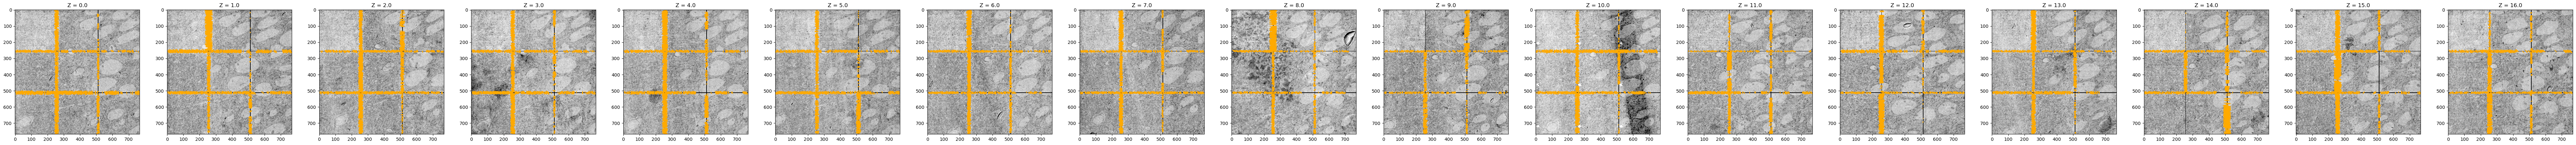

In [11]:
plotting.plot_matches(
    stack=stack,
    match_collection=match_collection,
    z_values=None,
    width=256,
    **params_render
)

## Stitching (part II)
---

### Create alignment files

In [12]:
from pathlib import Path
import os
import subprocess
import json
from pprint import pprint

In [13]:
# Load align.json template
template_align_json = Path('../templates/montage.json')
with template_align_json.open('r') as json_data:
    params_align = json.load(json_data)

# Loop through sections
for z in tqdm(z_values):

    # Edit BigFeta solver schema
    params_align['first_section'] = z
    params_align['last_section'] = z
    params_align['transformation'] = 'TranslationModel'

    # Edit input stack data
    params_align['input_stack']['host'] = params_render['host']
    params_align['input_stack']['owner'] = params_render['owner']
    params_align['input_stack']['project'] = params_render['project']
    params_align['input_stack']['name'] = stack

    # Edit point match stack data
    params_align['pointmatch']['host'] = params_render['host']
    params_align['pointmatch']['owner'] = params_render['owner']
    params_align['pointmatch']['name'] = match_collection

    # Edit output stack data
    params_align['output_stack']['host'] = params_render['host']
    params_align['output_stack']['owner'] = params_render['owner']
    params_align['output_stack']['project'] = params_render['project']
    params_align['output_stack']['name'] = f"{stack}_stitched"

    # Edit regularization parameters
    params_align['regularization']['default_lambda'] = 0.005      # default: 0.005
    params_align['regularization']['translation_factor'] = 0.005  # default: 0.005

    # Export montage settings to
    sectionId = renderapi.stack.get_sectionId_for_z(stack, z, **params_render)
    align_json = dir_project / f"{sectionId}/{stack}/montage.json"
    with align_json.open('w') as json_data:
        json.dump(params_align, json_data, indent=2)

# Check alignment parameters
print(align_json)
print('-'*len(align_json.as_posix()))
pprint(params_align)

  0%|          | 0/17 [00:00<?, ?it/s]

/long_term_storage/asm_storage/asm_service/2023-07-12/20230712_RF_zstack/RF_brain_section_18_10us/corrected/montage.json
------------------------------------------------------------------------------------------------------------------------
{'close_stack': 'True',
 'first_section': 16,
 'hdf5_options': {'chunks_per_file': -1, 'output_dir': ''},
 'input_stack': {'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
                 'collection_type': 'stack',
                 'db_interface': 'render',
                 'host': 'http://localhost',
                 'name': 'corrected',
                 'owner': 'fastem',
                 'port': 8081,
                 'project': '20230712_RF_zstack'},
 'last_section': 16,
 'log_level': 'INFO',
 'matrix_assembly': {'cross_pt_weight': 1.0,
                     'depth': 2,
                     'inverse_dz': 'True',
                     'montage_pt_weight': 1.0,
                     'npts_max': 500,
                

### Compute optimal transformations with `BigFeta`

In [14]:
# Path to `BigFeta`
cwd = Path.cwd().as_posix()
dir_BigFeta = Path('/home/rlane/BigFeta/')

# Loop through z values
for z in z_values:

    # Select montage json
    sectionId = renderapi.stack.get_sectionId_for_z(stack, z, **params_render)
    align_json = dir_project / f"{sectionId}/{stack}/montage.json"

    # Call `BigFeta.BigFeta` process -- have to switch to BigFeta directory
    os.chdir(dir_BigFeta.as_posix())
    subprocess.run(['python', '-m', 'bigfeta.bigfeta', '--input_json', align_json.as_posix()])
    os.chdir(cwd)

/home/rlane/miniconda3/envs/render/lib/python3.11/site-packages/argschema/utils.py:346: FutureWarning: '--transform_apply' is using old-style command-line syntax with each element as a separate argument. This will not be supported in argschema after 2.0. See http://argschema.readthedocs.io/en/master/user/intro.html#command-line-specification for details.
  warnings.warn(warn_msg, FutureWarning)
INFO:bigfeta.utils:
 loaded 9 tile specs from 1 zvalues in 0.0 sec using interface: render
INFO:__main__: A created in 0.1 seconds
INFO:__main__:
 solved in 0.0 sec
 precision [norm(Kx-Lm)/norm(Lm)] = 1.3e-16, 2.2e-16
 error     [norm(Ax-b)] = 341.877, 200.133
 [mean(Ax) +/- std(Ax)] : 0.0 +/- 7.4, 0.0 +/- 4.3
 [mean(error mag) +/- std(error mag)] : 7.5 +/- 4.2
INFO:__main__:
 scales: 1.00 +/- 0.00, 1.00 +/- 0.00
INFO:bigfeta.utils:
ingesting results to http://localhost:8081 fastem__20230712_RF_zstack__corrected_stitched
INFO:bigfeta.utils:render output is going to /dev/null
INFO:__main__: total

### Inspect

In [16]:
# Plot stacks
stacks = ["corrected", "corrected_stitched"]
plotting.plot_stacks(
    stacks,
    params_render
)

  0%|          | 0/2 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=0, description='z', max=16), IntSlider(value=30201, description='vmin', …